In [241]:
from sklearn.preprocessing import MinMaxScaler
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')
stopwords = set(english_stopwords)
import json
import pandas as pd
from tqdm import tqdm

In [242]:
import nltk
from nltk.corpus import stopwords
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 50))
# read card_deck from ppn_deck.json file
with open("ppn_deck.json", "r") as read_file:
    card_deck = json.load(read_file)

def revise_point_values(card_deck, max_points=50):
    # Initialize a dictionary to store the word counts for each card
    word_counts = {}
    # Initialize a list to store the word counts for each card
    card_word_counts = []
    related_words = []
    # Get a list of English stopwords
    stop_words = stopwords.words("english")
    
    # Iterate through each card in the card deck
    card_id = 0
    for card in tqdm(card_deck):
        # Get the card's id from the iteration
        # Get the summary for the card
        summary = card['summary']
        # Split the summary into words. Currently it is a tuple, get the second element.
        summary_text = summary[1]
        # Split the summary into words
        words = summary_text.split()
        # Remove the stop words from the list of words
        nonstop_words = [word for word in words if word not in stop_words]
        # Calculate the number of non-stop words
        word_count = len(nonstop_words)
        # Add the word count to the dictionary
        word_counts[card_id] = word_count
        # Append the word count to the list of card word counts
        card_word_counts.append(word_count)
        # append related words to card deck
        try:
            related_words.append(int(card['related']))
        except:
            related_words.append(0)

        # Increment the card id
        card_id += 1
    # Scale the word counts to be between 0 and 10
    scaled_word_counts = scaler.fit_transform(pd.DataFrame(card_word_counts))
    # Iterate through each card in the card deck
    card_id = 0
    for card in tqdm(card_deck):
        #print(card)
        # Get the card's id from the iteration
        # Get the scaled word count for the card
        scaled_word_count = scaled_word_counts[card_id]
        # Get the card's point value if it exists
        # point_value = card['point_value'] if 'point_value' in card else 0
        related_words = int(card['related'])
        
        rounded_value = int(scaled_word_count[0])

        # Update the card's point value to the scaled word count
        try:
            card['point_value'] = max(rounded_value, related_words)
            print(card['point_value'])
        except Exception as e:
            print(e)
            print(card['point_value'])
            print(rounded_value)
            print(related_words)
            print(card)
        # Increment the card id
        card_id += 1
    return card_deck
    


To fix this, you can reshape card_word_counts to a 2D array using the reshape method of the numpy library, like this: card_word_counts.reshape(-1, 1). This will transform card_word_counts into a 2D array with a single column and as many rows as there are elements in card_word_counts.

You can then pass the reshaped array to the fit method of the MinMaxScaler object.

You will also need to make the same change to the line card_word_counts_scaled = scaler.fit_transform(card_word_counts.reshape(-1, 1)) in order to avoid the same error when you try to fit the scaler to the data.

Finally, in the for loop where you update the point value for each card, you should use card_word_counts_scaled[card_id] instead of card_word_counts_scaled[word_count]. This is because card_word_counts_scaled is a list of scaled word counts, and you need to use the current card_id to index into the list

In [253]:
# Now assign points based on the related column but scale it with MinMaxScaler
# card_deck = revise_point_values(card_deck, max_points=50)
scaler = MinMaxScaler(feature_range=(0, 20))
# read card_deck from ppn_deck.json file
with open("ppn_deck.json", "r") as read_file:
    card_deck = json.load(read_file)

def revise_point_values(card_deck, max_points=20):
    # Initialize a dictionary to store the word counts for each card
    word_counts = {}
    # Initialize a list to store the word counts for each card
    card_word_counts = []
    related_words = []
    # Get a list of English stopwords
    stop_words = stopwords.words("english")
    
    # Iterate through each card in the card deck
    card_id = 0
    for card in tqdm(card_deck):
        # Get the card's id from the iteration
        # Get the summary for the card
        summary = card['summary']
        # Split the summary into words. Currently it is a tuple, get the second element.
        summary_text = summary[1]
        # Split the summary into words
        words = summary_text.split()
        # Remove the stop words from the list of words
        nonstop_words = [word for word in words if word not in stop_words]
        # Calculate the number of non-stop words
        word_count = len(nonstop_words)
        # Add the word count to the dictionary
        word_counts[card_id] = word_count
        # Append the word count to the list of card word counts
        card_word_counts.append(word_count)
        # append related words to card deck
        try:
            related_words.append(int(card['related']))
        except:
            related_words.append(0)

        # Increment the card id
        card_id += 1
    # Scale the word counts to be between 0 and 10
    scaled_word_counts = scaler.fit_transform(pd.DataFrame(related_words))
    # Iterate through each card in the card deck
    card_id = 0
    for card in tqdm(card_deck):
        #print(card)
        # Get the card's id from the iteration
        # Get the scaled word count for the card
        try:
            scaled_word_count = scaled_word_counts[card_id]
            # Get the card's point value if it exists
            # point_value = card['point_value'] if 'point_value' in card else 0
            related_words = int(card['related'])
            
            rounded_value = int(scaled_word_count[0])
        except:
            related_words = 0
            rounded_value = 0
        # Update the card's point value to the scaled word count
        try:
            card['point_value'] = max(rounded_value, related_words)
            # print(card['point_value'])
        except Exception as e:
            #print(e)
            # print(card['point_value'])
            # print(rounded_value)
            # print(related_words)
            # print(card)
            pass
        # Increment the card id
        card_id += 1
    return card_deck

# Now assign points based on the related column but scale it with MinMaxScaler
card_deck = revise_point_values(card_deck, max_points=50)

100%|██████████| 6850/6850 [00:00<00:00, 811036.91it/s]


In [244]:
import json
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from nltk.corpus import stopwords

scaler = MinMaxScaler(feature_range=(0, 20))

with open("ppn_deck.json", "r") as read_file:
    card_deck = json.load(read_file)

def revise_point_values(card_deck, max_points=20):
    stop_words = stopwords.words("english")
    card_id = 0
    related_words = []
    for card in card_deck:
        summary_text = card['summary'][1]
        words = summary_text.split()
        nonstop_words = [word for word in words if word not in stop_words]
        word_count = len(nonstop_words)
        try:
            related_words.append(int(card['related']))
        except:
            related_words.append(0)
        card_id += 1
    scaled_word_counts = scaler.fit_transform(pd.DataFrame(related_words))
    card_id = 0
    for card in card_deck:
        try:
            scaled_word_count = scaled_word_counts[card_id]
            related_words = int(card['related'])
            rounded_value = int(scaled_word_count[0])
        except:
            related_words = 0
            rounded_value = 0
        try:
            card['point_value'] = max(rounded_value, related_words)
        except Exception:
            pass
        card_id += 1
    return card_deck

card_deck = revise_point_values(card_deck, max_points=50)


In [245]:

# show an example with the revised point values
# convert to dataframe
df = pd.DataFrame(card_deck)
# show the first 5 rows
df.head()

,title,summary,related,summary_short,summary_clean,point_value
0,Climate change and cities,Climate change and cities are deeply connected...,401,Climate change and cities are deeply connected...,Moreover because of processes that create clim...,401
1,Rosetta Cammeniti,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",321,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",NaN,321
2,Spy Muppets: License to Croak,"Spy Muppets: License to Croak, Spy Muppets: Li...",164,"Spy Muppets: License to Croak, Spy Muppets: Li...",NaN,164
3,Fame in the 20th Century,"Fame in the 20th Century, Fame in the 20th Cen...",591,"Fame in the 20th Century, Fame in the 20th Cen...",NaN,591
4,Becca Hayton,"Becca Hayton, Becca Dean also Hayton is a fict...",271,"Becca Hayton, Becca Dean also Hayton is a fict...",NaN,271


In [246]:
# the summary_short needs to always be the second element in the tuple if it is an instance of a tuple, else it is itself (str)
for card in card_deck:
    summary = card['summary']
    if isinstance(summary, tuple) or isinstance(summary, list):
        summary_short = summary[1]
    else:
        summary_short = summary
    card['summary_short'] = summary_short
    card['summary'] = summary_short

df = pd.DataFrame(card_deck)

In [247]:
# revise point values
card_deck = revise_point_values(card_deck,20)


In [248]:
# the point_value must always be a value from 1 to 10 never 0. Replace all 0's with 1's
df['point_value'] = df['point_value'].replace(0,1)


In [249]:
df.head()

,title,summary,related,summary_short,summary_clean,point_value
0,Climate change and cities,Climate change and cities are deeply connected...,401,Climate change and cities are deeply connected...,Moreover because of processes that create clim...,401
1,Rosetta Cammeniti,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",321,"Rosetta Cammeniti, Rosetta Rosie Cammeniti is ...",NaN,321
2,Spy Muppets: License to Croak,"Spy Muppets: License to Croak, Spy Muppets: Li...",164,"Spy Muppets: License to Croak, Spy Muppets: Li...",NaN,164
3,Fame in the 20th Century,"Fame in the 20th Century, Fame in the 20th Cen...",591,"Fame in the 20th Century, Fame in the 20th Cen...",NaN,591
4,Becca Hayton,"Becca Hayton, Becca Dean also Hayton is a fict...",271,"Becca Hayton, Becca Dean also Hayton is a fict...",NaN,271


<AxesSubplot: >

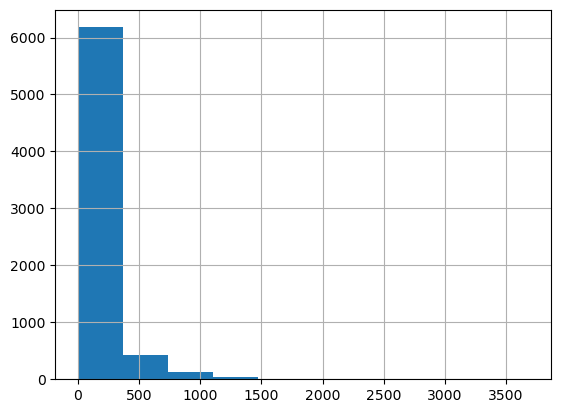

In [250]:
# plot a histogram of the point values
df['point_value'].hist()

In [251]:
# now save the df as a json file
card_deck = df.to_dict('records')
with open("ppn_deck.json", "w") as write_file:
    json.dump(card_deck, write_file)
